In [227]:
from datasets import load_dataset
from tqdm import tqdm
import torch
   
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [228]:
# dataset = load_dataset('cifar10', cache_dir='/data')
# dataset.set_format(type='torch')
# dataset


In [229]:
# dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=8)

In [230]:
# dataset['train'].

from torchvision import datasets 
from torchvision import transforms
#transform = transforms.Compose([transforms.Resize((224,224)),  transforms.ToTensor()])
transform = transforms.Compose([  transforms.ToTensor(), transforms.Lambda(lambda x: x.to(device))])
to_device_transform = transforms.Compose([
    
    transforms.Lambda(lambda x: x.to(device))])

dataset = datasets.CIFAR10(root='data', train = True, download=True, transform = transform)#, target_transform=to_device_transform)
#dataloader = data_loader(data_dir='./data', batch_size=32)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

transform = transforms.Compose([  transforms.ToTensor(), transforms.Lambda(lambda x: x.to(device))])
to_device_transform = transforms.Compose([
    
    transforms.Lambda(lambda x: x.to(device))])

dataset = datasets.CIFAR10(root='data', train = False, download=True, transform = transform)#, target_transform=to_device_transform)
#dataloader = data_loader(data_dir='./data', batch_size=32)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [236]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x.to(device))])
dataset = datasets.ImageFolder('data', transform = transform)


train, test = torch.utils.data.random_split(dataset, [270,50])

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

In [237]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = stride, padding = 1),  #outputs the same size on default
            nn.BatchNorm2d(out_channels),
            nn.ReLU()           
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1 ),  #outputs the same size
        nn.BatchNorm2d(out_channels)
        ) 
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if (self.downsample):
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [306]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
        
        self.last_conv = torch.nn.Conv2d(in_channels = 512, out_channels = num_classes, kernel_size = 1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        #print('before avgpool shape is', x.shape)
        
        #x = self.avgpool(x)
        #
        
        
        #x = self.fc(x)
        x = self.last_conv(x)
        
        
        
        x = x.view(x.size(0), -1)

        return x
        
    
    
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride), 
                                        nn.BatchNorm2d(planes)
                                    )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    

In [307]:
num_classes = 10
num_epochs = 30
batch_size = 16
learining_rate = 0.001
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=2).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learining_rate, weight_decay = 0.001, momentum = 0.9)

total_step = len(dataset)

In [308]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        
        output = model(images)
        labels = torch.tensor(labels).to(device)

        
        #print(labels.shape)
        #print(output.shape)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        

  0%|                                                                                          | 0/270 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_12508\3335146879.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:07<00:00, 37.66it/s]


In [309]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))  

Accuracy of the network on the 50 test images: 98.0 %


In [310]:
torch.save(model.state_dict(), '98.pt')

# А теперь используем

In [312]:
import matplotlib.pyplot as plt
import cv2
import os

from time import sleep

In [313]:
def plot(img):
    if str(type(img)) == "<class 'numpy.ndarray'>":
        plt.imshow(img)
        plt.show()
    else:
        print("I don't know how to plot: ", (type(img)))

In [314]:
test_loader.dataset.dataset.classes

['pechat', 'propis']

In [368]:
img_folder = 'imgs'


propis = []
pechat = []

model.eval = True
for i, image in tqdm(enumerate(os.listdir(img_folder)), total=len(os.listdir(img_folder))):
    img = cv2.imread(os.path.join(img_folder, image))
    #print(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = pytorch.tensor(img)
    
    
    #plot(img)

    img = transforms.ToTensor()(img)
    img = img.transpose(0, 0)
    img = torch.unsqueeze(img, dim=0)
#     print(img.shape)
    img = img.to(device)
    try:
        predicted = model(img)
    except:
        print('ERROR with', image)
        continue
    predicted = predicted[0][:2]
    #print(predicted.shape)
    predicted = torch.unsqueeze(predicted, dim=0)
    _, predicted = torch.max(predicted.data, 1)
    
    result = test_loader.dataset.dataset.classes[int(predicted[0])]
    #print(result)
    if result == 'pechat':
        pechat.append(image)
    else:
        propis.append(image)
    #print('\n'*2)
    #if i == 100:
    #    break

  3%|██▍                                                                         | 3904/121666 [00:44<21:24, 91.67it/s]

ERROR with 0908c8e4c1c3467594832a575daadf21.png


  4%|██▉                                                                         | 4684/121666 [00:52<22:02, 88.47it/s]

ERROR with 0af24db964eb43f1bcb529019e554374.png


  4%|███▏                                                                        | 5197/121666 [00:58<21:41, 89.47it/s]

ERROR with 0bfd238bead04d0ba9858665274c9593.jpeg


  4%|███▎                                                                        | 5326/121666 [01:00<21:41, 89.38it/s]

ERROR with 0c4be465a6f548fe94e101a46de26bfb.jpeg


  4%|███▎                                                                        | 5392/121666 [01:00<22:28, 86.21it/s]

ERROR with 0c7ad044c1084afbad469fb97f81a087.png


  4%|███▍                                                                        | 5448/121666 [01:01<21:41, 89.30it/s]

ERROR with 0c92d95e55374f8f8790859a98f004cf.jpeg


  5%|███▍                                                                        | 5487/121666 [01:02<21:44, 89.07it/s]

ERROR with 0ca1bcdfdfbd4578a46698f5c9b540ff.jpeg


  5%|███▍                                                                        | 5534/121666 [01:02<21:42, 89.13it/s]

ERROR with 0cba26c669de4276bd6be6b2d23dc1aa.png


  5%|███▍                                                                        | 5559/121666 [01:02<21:52, 88.48it/s]


KeyboardInterrupt: 

tensor([49], device='cuda:0')

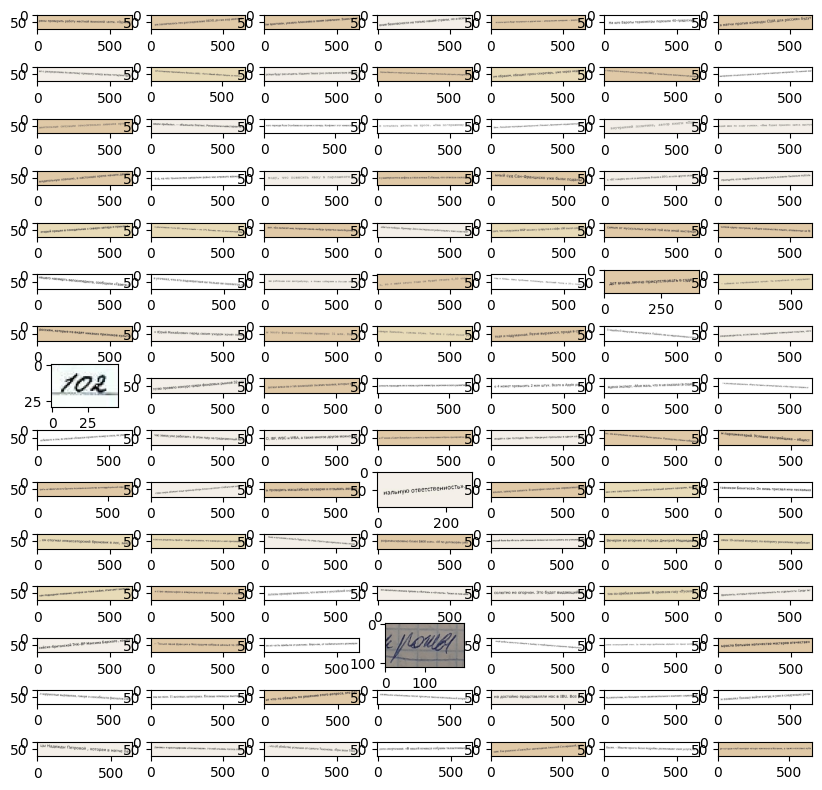

In [369]:
fig = plt.figure(figsize=(10, 10))
columns = 7
rows = 15
for i in range(1, columns*rows + 1):
    img = cv2.imread(os.path.join(img_folder,pechat[i]))
    #print(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [366]:
import shutil
for image in tqdm(pechat, total=len(pechat)):
    path_from = os.path.join(img_folder, image)
    path_to = os.path.join('ai_pechat', image)
    #print(path_from)
    #print(path_to)
    
    shutil.move(path_from, path_to)
    

  0%|                                                                                          | 0/311 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'imgs\\00001fca8f4542ed8ccc643cbec4b69a.jpeg'

In [ ]:
data = datasets.ImageFolder('imgs', transform = transform)


In [ ]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x.to(device))])
dataset = datasets.ImageFolder('data', transform = transform)


train, test = torch.utils.data.random_split(dataset, [200,120])

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)